In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 프로젝트 루트 경로를 sys.path에 추가
project_root = os.path.abspath("..")  # notebooks 폴더 기준 상위 폴더
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scripts.utils import setup_font

# 시각화 스타일 설정
sns.set_style("whitegrid")
sns.set_palette('Set2')

In [6]:
daycare_df = pd.read_csv("../data/processed/result/daycare_air_quality_with_distance.csv", encoding="utf-8")

/var/folders/2x/x768sjcx2ds8_1npxt7wbhym0000gn/T/ipykernel_97077/3045450076.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  daycare_df = pd.read_csv("../data/processed/result/daycare_air_quality_with_distance.csv", encoding="utf-8")


In [8]:
monitoring_station_df = pd.read_csv("../data/raw/monitoringStation/seoul_monitoring_stations.csv", encoding='utf-8')

In [9]:
from scripts.utils import add_month_column

daycare_df = add_month_column(daycare_df)

In [10]:
selected_columns = ["pm10", "pm25", "평균기온(°C)", "일강수량(mm)", "평균 풍속(m/s)", "month"]

In [11]:
from scripts.model_utils import split_features_and_target

# 결측치 제거
daycare_df = daycare_df.dropna(subset=selected_columns)

# 숫자형 컬럼을 float으로 변환
daycare_df[selected_columns] = daycare_df[selected_columns].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# 예측용: PM2.5를 포함한 전체 특성 데이터프레임 (학습/예측용)
X_with_pm25, y_with_pm25, X_train_with_pm25, X_test_with_pm25, y_train_with_pm25, y_test_with_pm25 = \
    split_features_and_target(daycare_df, target_column="pm10", use_pm25=True)

# 참고:
# - X_with_pm25: 특성(feature) 데이터프레임 (pm25 포함)
# - y_with_pm25: 타겟(target) 시리즈 (pm10)
# - X_train_with_pm25, X_test_with_pm25: 학습용/테스트용 특성 데이터프레임
# - y_train_with_pm25, y_test_with_pm25: 학습용/테스트용 타겟 시리즈

# 해석용: PM2.5를 제외한 특성 데이터프레임
X_no_pm25, y_no_pm25, X_train_no_pm25, X_test_no_pm25, y_train_no_pm25, y_test_no_pm25 = \
    split_features_and_target(daycare_df, target_column="pm10", use_pm25=False)

# 참고:
# - X_no_pm25: PM2.5를 제외한 특성 데이터프레임
# - y_no_pm25: 타겟 (PM10)

In [12]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train_with_pm25, y_train_with_pm25)

y_pred_lr = linear_model.predict(X_test_with_pm25)

Current OS: Darwin
Setting macOS font: AppleGothic
Current font settings: ['AppleGothic']


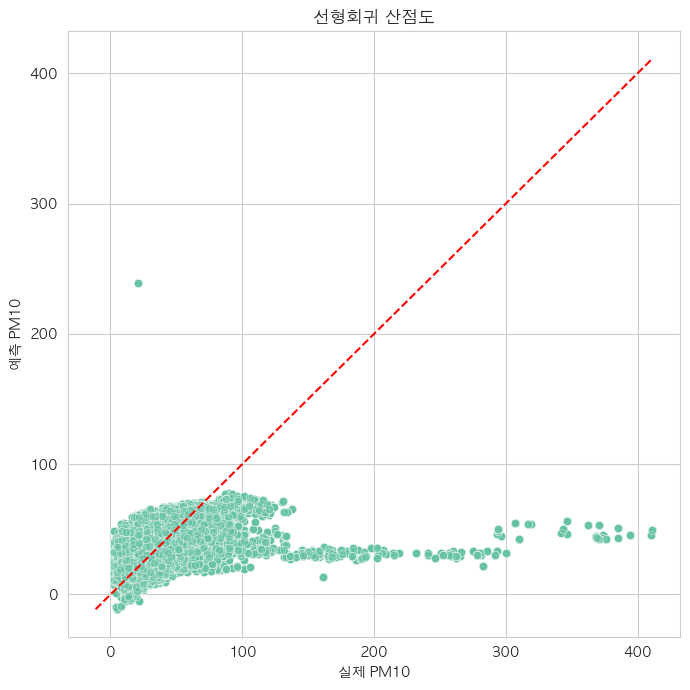

In [13]:
from scripts.visualization import plot_scatter_prediction

setup_font()

plot_scatter_prediction(y_test_with_pm25, y_pred_lr, "선형회귀 산점도")


선형회귀 성능 지표
 - MSE: 231.9314
 - RMSE: 15.2293
 - MAE: 9.4476
 - R²: 0.3406


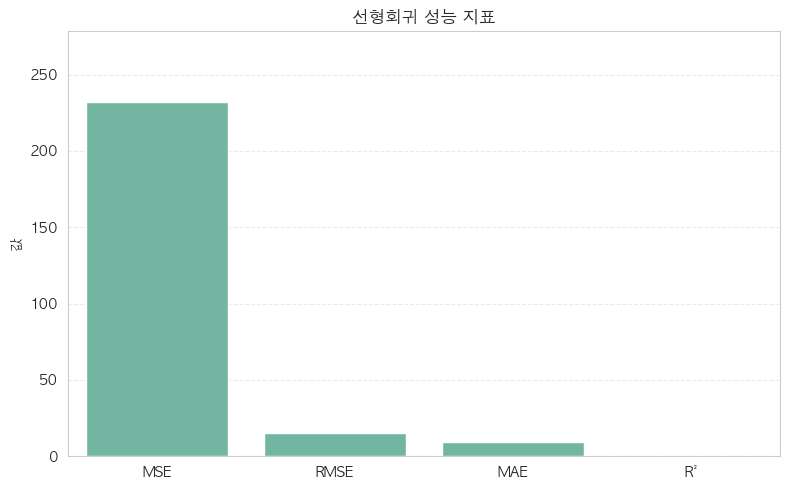

In [14]:
from scripts.model_utils import get_evaluate_regression_scores
from scripts.visualization import plot_regression_metrics_bar

scores_lr = get_evaluate_regression_scores(y_test_with_pm25, y_pred_lr)
plot_regression_metrics_bar(scores_lr, "선형회귀")

### 의사결정트리에서 PM2.5를 제거한 데이터셋으로 학습한 이유

모델을 통해 얻고자 하는 목적에 따라 입력 변수 구성에 차이를 두었습니다.  
특히, `해석 가능한 모델(의사결정트리)`에서는 **PM2.5를 제거하는 것이 더 적절하다**고 판단했습니다.  
그 이유는 다음과 같습니다:

1. PM10과 PM2.5는 포함 관계이지만, 해석 관점에서는 독립적인 변수

	- PM10은 지름이 10μm 이하인 입자, PM2.5는 그중 더 작은 2.5μm 이하의 초미세입자를 의미합니다.
	- **수학적으로는 PM2.5가 PM10의 부분집합**이지만,  
	**화학적 성질, 생성 경로, 건강 영향 등이 달라 독립 변수로 해석할 수 있습니다.**
	- 예를 들어, PM10은 황사나 큰 먼지에서 주로 발생하지만, PM2.5는 연소 과정이나 화학반응으로 생성됩니다.

2. PM2.5는 PM10의 직접적인 구성 요소

	- PM2.5 수치가 높으면 자연스럽게 PM10 수치도 함께 높아질 가능성이 있습니다.
	- 따라서 **예측 모델에서는 성능 향상을 위해 포함시키는 것이 유리**합니다.
	- 그러나 **해석이 목적이라면 종속변수(PM10)의 일부를 독립변수로 넣는 것은 적절하지 않습니다.**  
	→ 이는 **해석의 신뢰성을 떨어뜨리고, 원인 분석의 명확성을 해칠 수 있습니다.**

3. 해석 목적에서는 ‘원인 추정’이 핵심

	- 예측 성능이 아닌, **기상 요인이나 월(month) 등의 외부 요인이 PM10에 어떤 영향을 주는지를 분석**하는 것이 목표입니다.
	- PM2.5를 포함할 경우, 모델이 **기상 요인보다 PM2.5를 중심으로 분기 기준을 형성할 가능성**이 높아집니다.
	- 이는 곧 **정책 수립이나 시각화 해석에 방해 요소**가 될 수 있습니다.

#### 결론

- **예측 모델 (Random Forest)**  
  → PM2.5를 포함하여 모델의 성능을 극대화

- **해석 모델 (Decision Tree)**  
  → PM2.5를 제거하여 **기상 요인이 PM10에 미치는 영향을 명확히 파악**하고  
    **원인 분석과 정책 제안에 적합한 모델로 설계**

In [15]:
from scripts.model_utils import train_decision_tree

# 의사 결정 트리는 해석용으로 활용하기에 pm25를 제외한 데이터셋으로 학습
decision_tree_model = train_decision_tree(X_train_no_pm25,y_train_no_pm25)

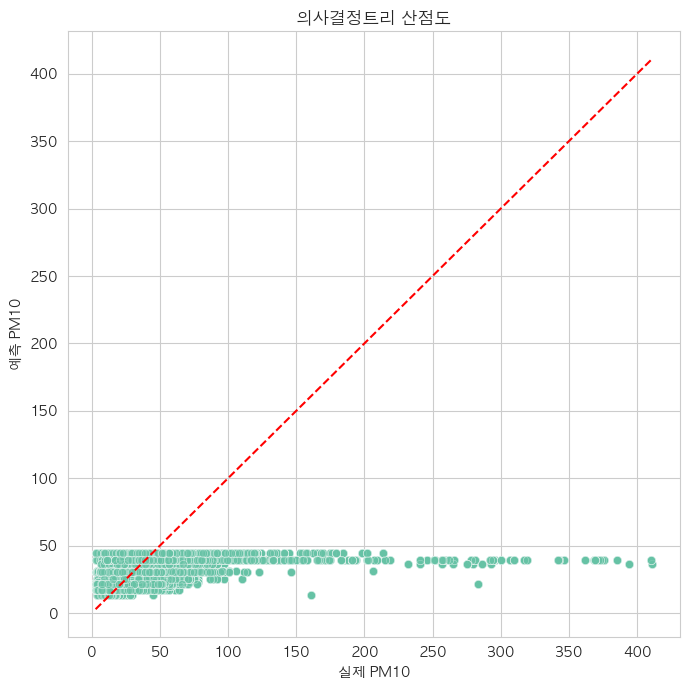

In [16]:
# 의사결정트리 예측값 (PM2.5 제외)
y_pred_dt = decision_tree_model.predict(X_test_no_pm25)
plot_scatter_prediction(y_test_no_pm25, y_pred_dt, "의사결정트리 산점도")

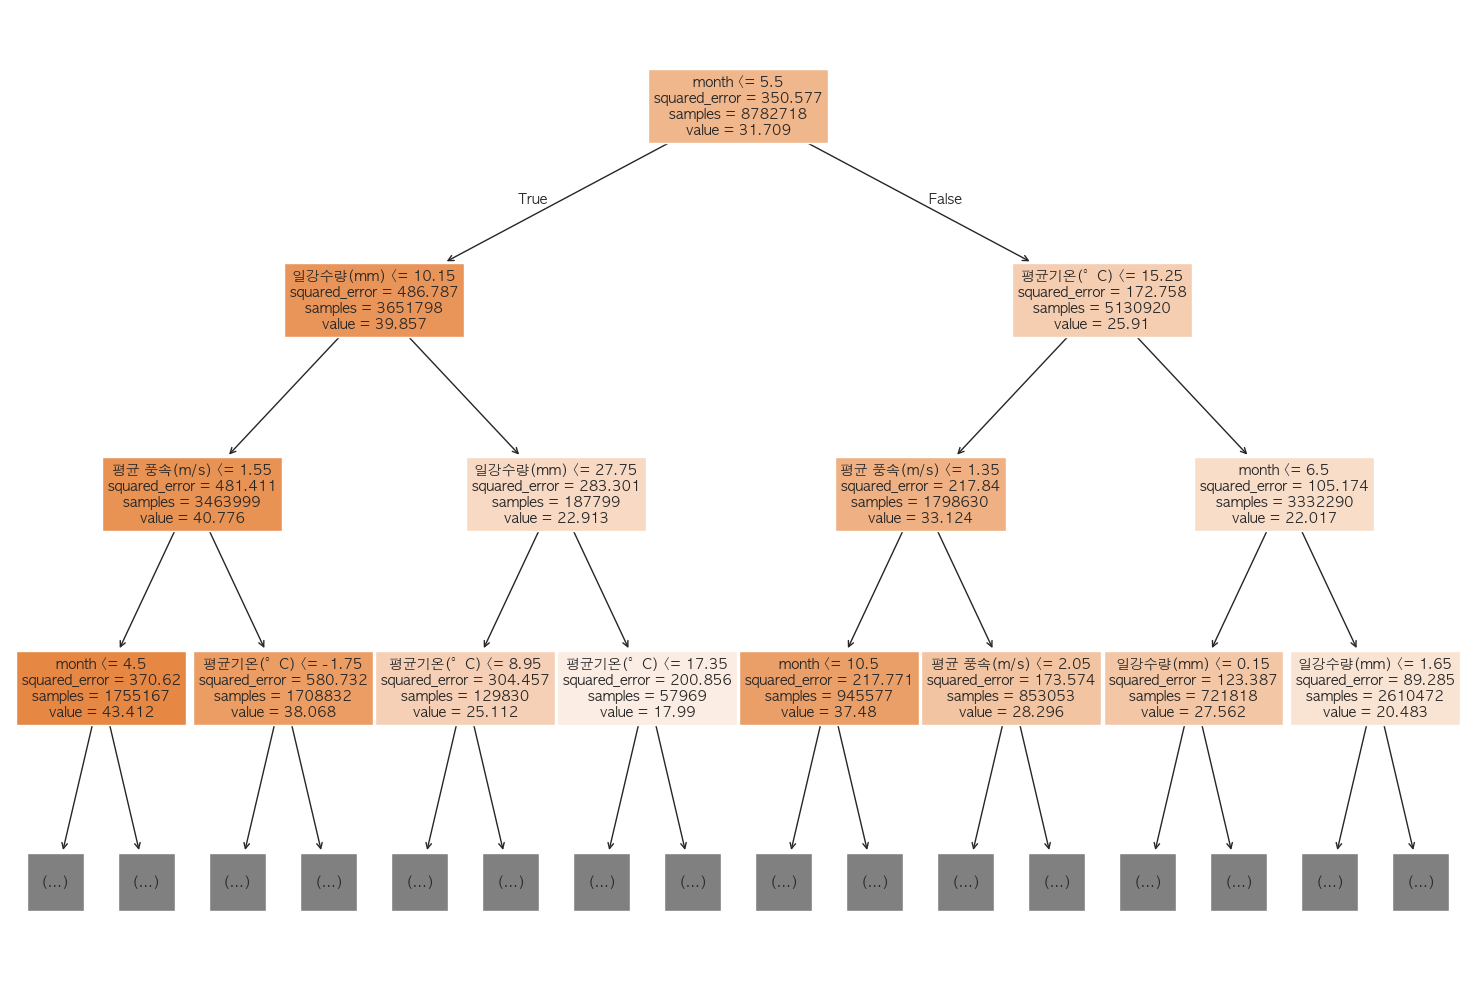

In [17]:
from scripts.model_utils import print_tree_rules
from scripts.visualization import plot_decision_tree

# 트리 구조를 텍스트로 출력 (입력 변수명을 함께 보여줌)
feature_names = X_no_pm25.columns.tolist()
tree_rules = print_tree_rules(decision_tree_model, feature_names)

plot_decision_tree(decision_tree_model, feature_names)


의사결정트리 성능 지표
 - MSE: 260.9521
 - RMSE: 16.1540
 - MAE: 10.4998
 - R²: 0.2560


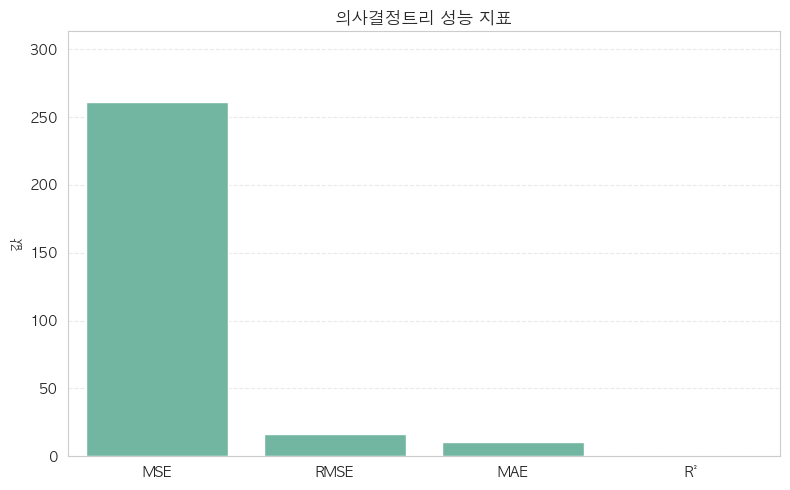

In [18]:
scores_dt = get_evaluate_regression_scores(y_test_no_pm25, y_pred_dt)
plot_regression_metrics_bar(scores_dt, "의사결정트리")

In [19]:
from scripts.utils import create_future_input

# 예시 입력 데이터 (각 구별로 평균 기상 조건을 입력, pm25는 입력하지 않음)
future_input = create_future_input(
    station_names=["강남구", "강동구", "강서구", "광진구"],
    month=3,    
    temp_list=[5.2, 4.8, 6.0, 5.5],
    rain_list=[1.2, 2.0, 0.8, 1.5],
    wind_list=[2.1, 2.3, 1.8, 2.0]
)

In [20]:
from scripts.model_utils import predict_pm10

predict_pm10(decision_tree_model, future_input, use_pm25=False).head()

,측정소명,month,평균기온(°C),일강수량(mm),평균 풍속(m/s),예측_PM10
0,강남구,3,5.2,1.2,2.1,39.447937
1,강동구,3,4.8,2.0,2.3,39.447937
2,강서구,3,6.0,0.8,1.8,39.447937
3,광진구,3,5.5,1.5,2.0,39.447937


In [21]:
from scripts.model_utils import train_random_forest

random_forest_model = train_random_forest(X_train_with_pm25, y_train_with_pm25)

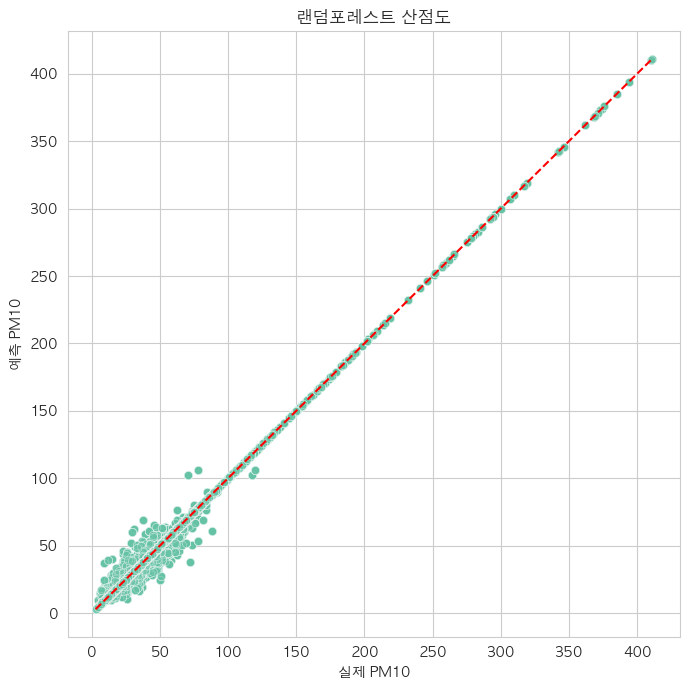

In [22]:
# 랜덤포레스트 예측값 (PM2.5 포함)
y_pred_rf = random_forest_model.predict(X_test_with_pm25)
plot_scatter_prediction(y_test_with_pm25, y_pred_rf, "랜덤포레스트 산점도")

In [23]:
estimator_list = random_forest_model.estimators_ # 의사결정트리 속성 확인

estimator_list[:10]

[DecisionTreeRegressor(max_features=1.0, random_state=1608637542),
 DecisionTreeRegressor(max_features=1.0, random_state=1273642419),
 DecisionTreeRegressor(max_features=1.0, random_state=1935803228),
 DecisionTreeRegressor(max_features=1.0, random_state=787846414),
 DecisionTreeRegressor(max_features=1.0, random_state=996406378),
 DecisionTreeRegressor(max_features=1.0, random_state=1201263687),
 DecisionTreeRegressor(max_features=1.0, random_state=423734972),
 DecisionTreeRegressor(max_features=1.0, random_state=415968276),
 DecisionTreeRegressor(max_features=1.0, random_state=670094950),
 DecisionTreeRegressor(max_features=1.0, random_state=1914837113)]

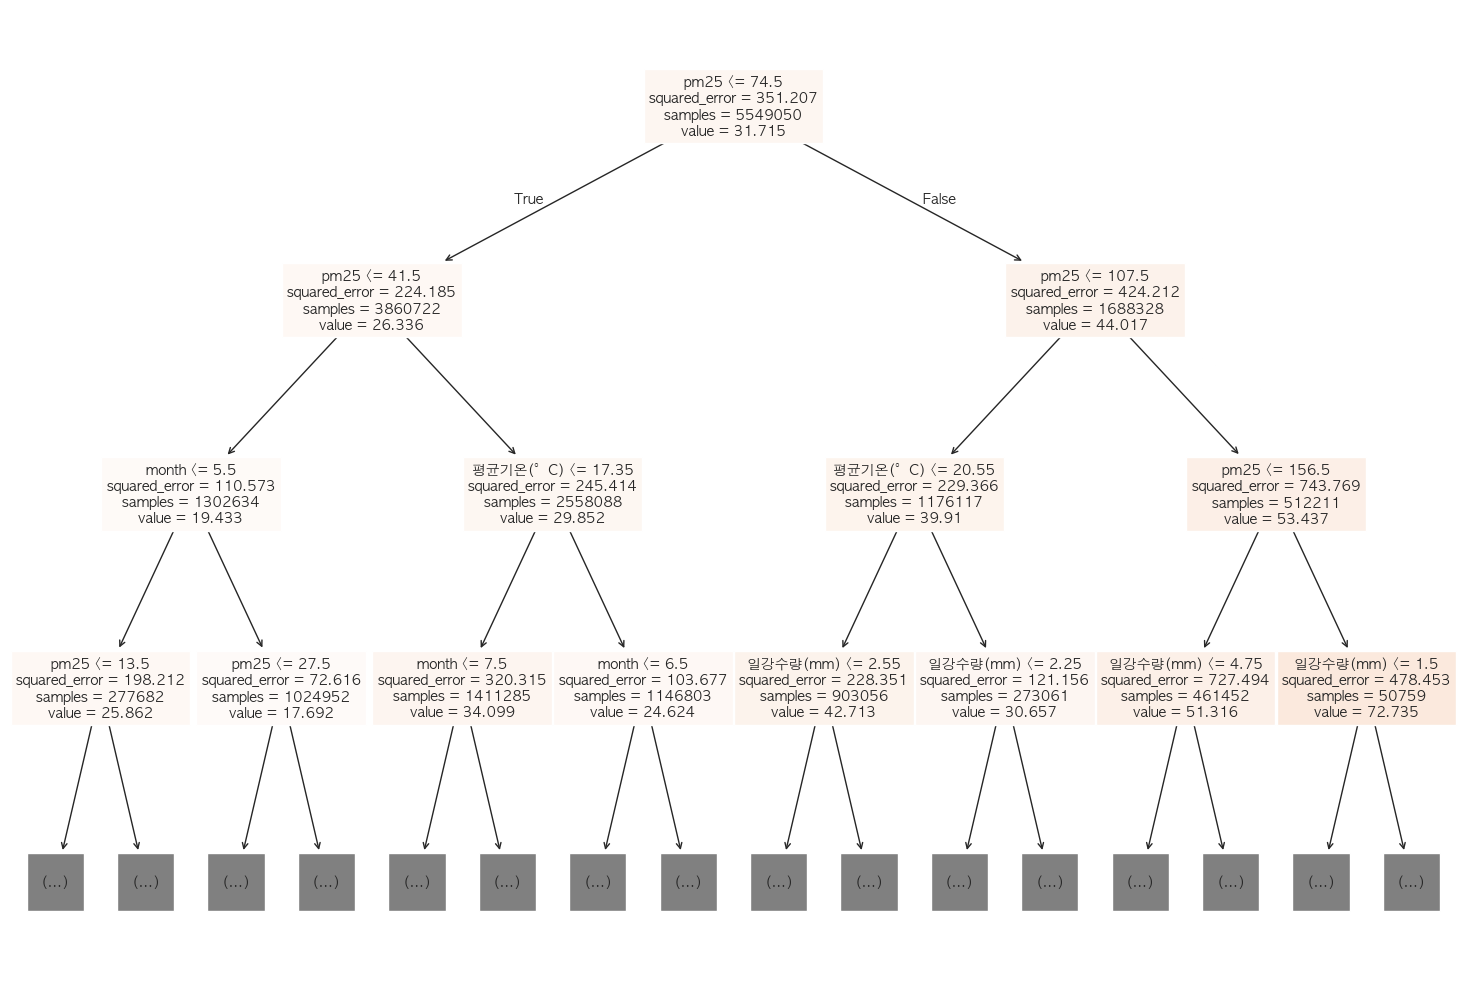

In [24]:
from scripts.visualization import plot_decision_tree

# 트리 구조를 텍스트로 출력 (입력 변수명을 함께 보여줌)
feature_names = X_with_pm25.columns.tolist()

plot_decision_tree(estimator_list[0], feature_names)


랜덤포레스트 성능 지표
 - MSE: 0.7598
 - RMSE: 0.8717
 - MAE: 0.0848
 - R²: 0.9978


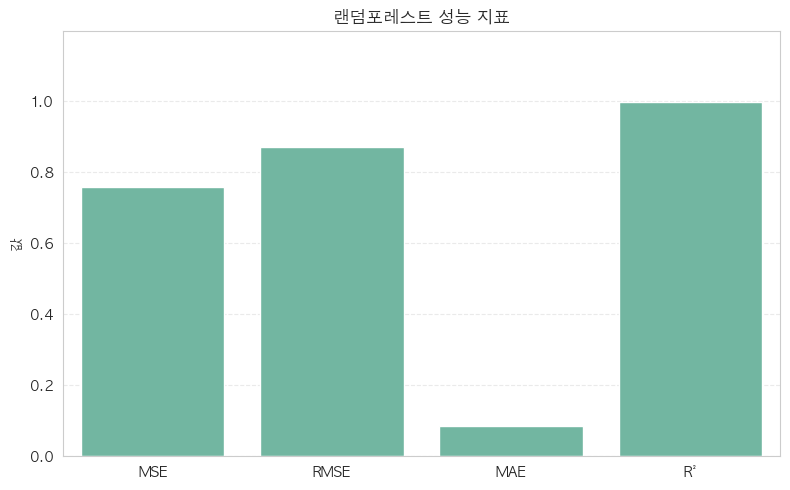

In [25]:
scores_rf = get_evaluate_regression_scores(y_test_with_pm25, y_pred_rf)
plot_regression_metrics_bar(scores_rf, "랜덤포레스트")

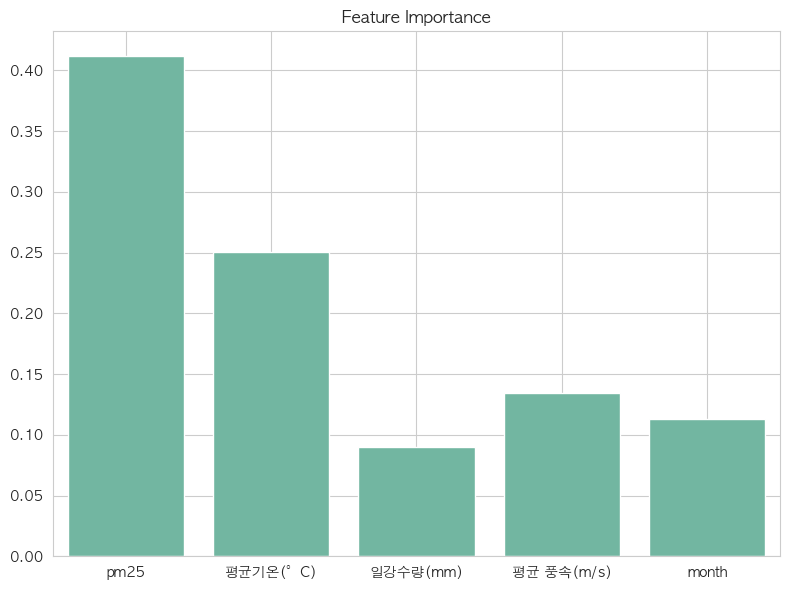

In [26]:
from scripts.visualization import plot_feature_importance

plot_feature_importance(random_forest_model)

In [27]:
future_input = create_future_input(
    station_names=["강남구", "강동구", "강서구", "광진구"],
    month=3,
    pm25_list=[25, 28, 26, 27],
    temp_list=[5.2, 4.8, 6.0, 5.5],
    rain_list=[1.2, 2.0, 0.8, 1.5],
    wind_list=[2.1, 2.3, 1.8, 2.0]
)

In [28]:
predict_pm10(random_forest_model, X_test_with_pm25)

,pm25,평균기온(°C),일강수량(mm),평균 풍속(m/s),month,예측_PM10
3257543,27.0,25.8,0.0,1.7,6,22.000000
3466341,59.0,31.2,0.0,1.3,8,23.538301
4118256,91.0,-3.7,0.0,1.0,1,43.000000
156924,55.0,2.7,0.0,0.8,12,38.000000
9399674,94.0,30.0,0.0,1.3,7,35.000000
...,...,...,...,...,...,...
3515620,86.0,13.1,0.0,2.1,3,22.000000
1462871,134.0,1.3,0.0,0.9,1,80.000000
3467468,45.0,28.5,0.5,1.3,8,23.000000
1810219,26.0,5.5,4.0,1.8,4,33.000000


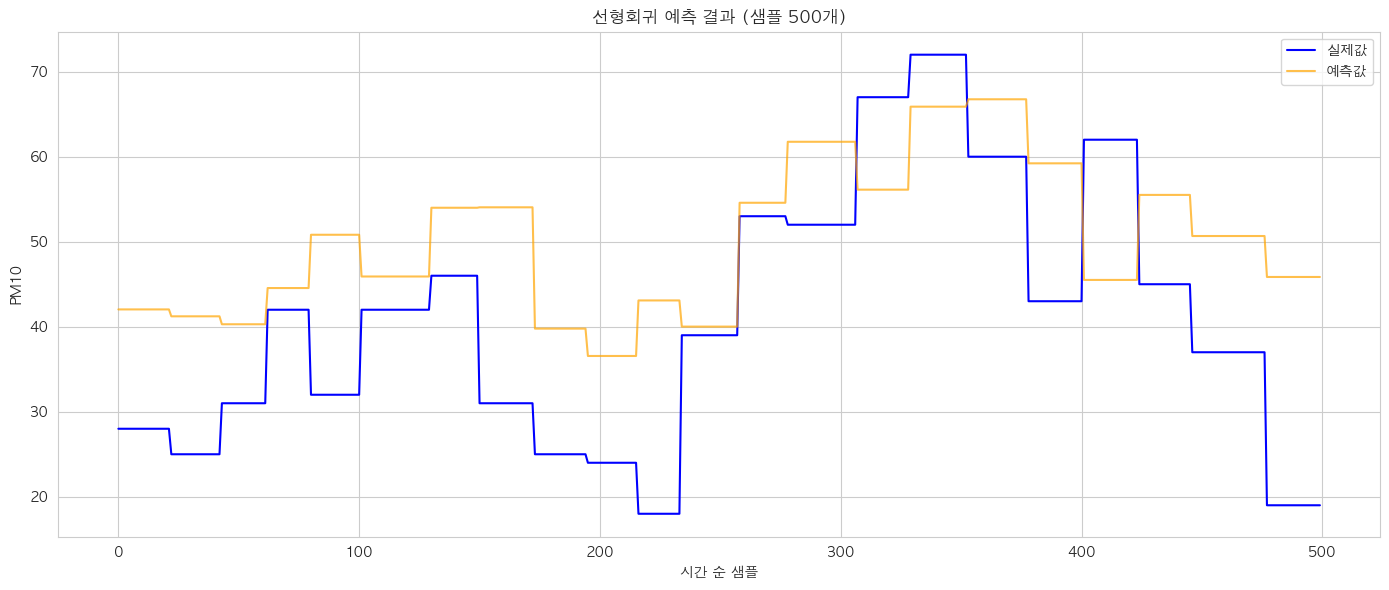

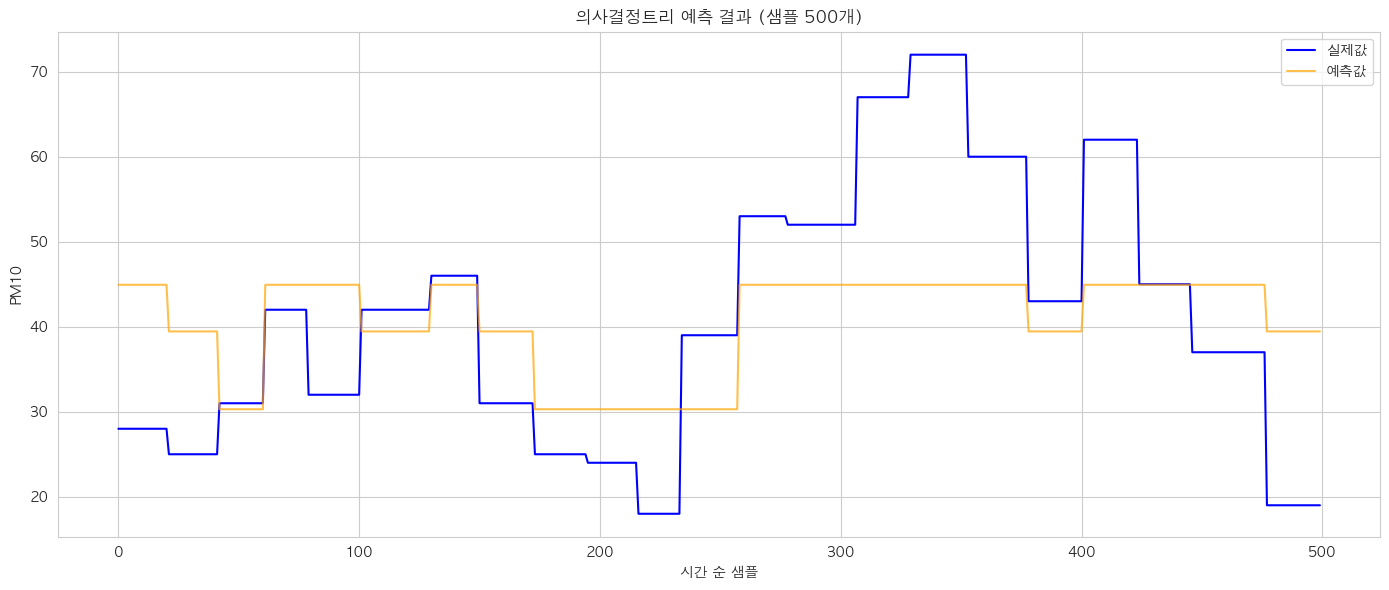

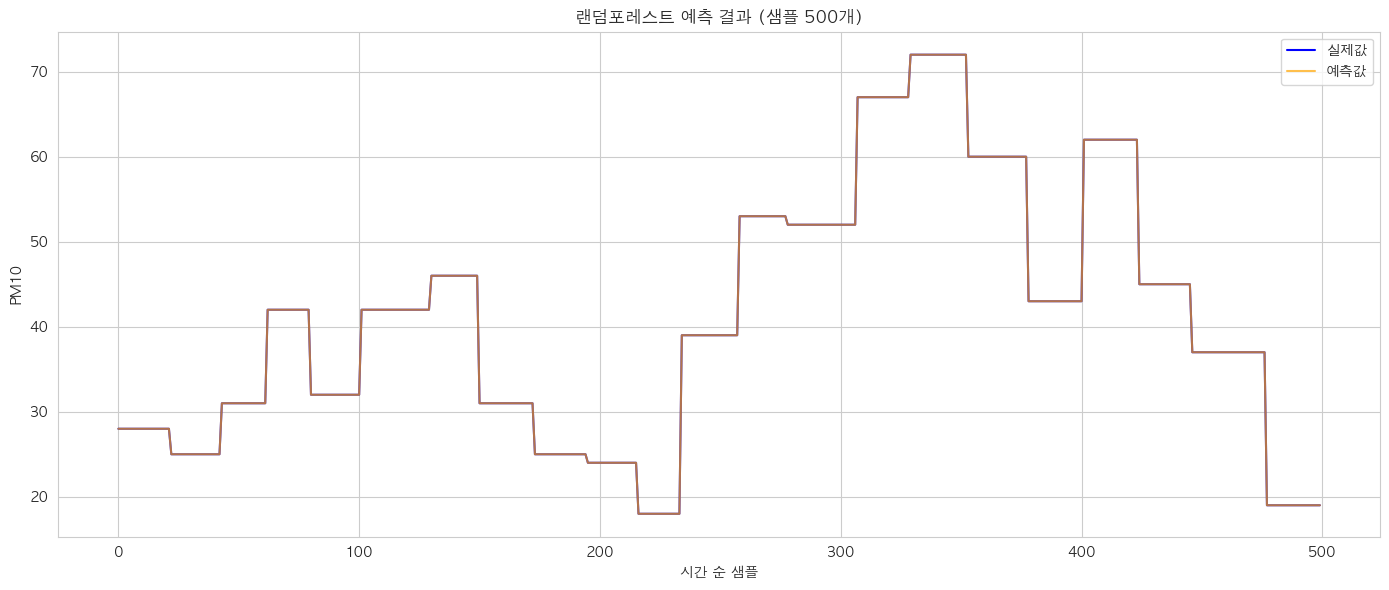

In [29]:
from scripts.visualization import plot_pm10_prediction_timeseries

plot_pm10_prediction_timeseries(linear_model, X_test_with_pm25, y_test_with_pm25, y_pred_lr, "선형회귀 예측 결과")
plot_pm10_prediction_timeseries(decision_tree_model, X_test_no_pm25, y_test_no_pm25, y_pred_dt, "의사결정트리 예측 결과")
plot_pm10_prediction_timeseries(random_forest_model, X_test_with_pm25, y_test_with_pm25, y_pred_rf, "랜덤포레스트 예측 결과")